<a href="https://colab.research.google.com/github/joshgregory42/practical_deep_learning/blob/main/ch_11_midlevel_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Munging with fastai's Mid-Level API

## Going Deeper into fastai's Layered API

In [1]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')

Factory method `TextDatLoaders.from_folder` is fine when the data is arranged in the exact same way as the IMDb dataset, but that usually doesn't happen. This is where the data block API offers more flexibility. Can get the same result with:

In [2]:
path = untar_data(URLs.IMDB)

dls = DataBlock(
    blocks=(TextBlock.from_folder(path), CategoryBlock),
    get_y = parent_label,
    get_items = partial(get_text_files, folders=['train', 'test']),
    splitter = GrandparentSplitter(valid_name='test')
).dataloaders(path)

## Transforms

When we looked at tokenization and numericlization, started by grabbing a bunch of texts:

In [3]:
files = get_text_files(path, folders = ['train', 'test'])
txts = L(o.open().read() for o in files[:2000])

In [4]:
# Tokenize with a tokenizer

tok = Tokenizer.from_folder(path)
tok.setup(txts)
toks = txts.map(tok)

toks[0]

(#190) ['xxbos','i','opted','to','see','the','film','at','the','recent'...]

In [5]:
# Numericalize

num = Numericalize()
num.setup(toks)

nums = toks.map(num)
nums[0][:10]

TensorText([   2,   18, 7936,   14,   91,    9,   33,   47,    9, 1415])

Can also use the `decode` method to get back the string tokens:

In [6]:
nums_dec = num.decode(nums[0][:10]);

nums_dec

(#10) ['xxbos','i','opted','to','see','the','film','at','the','recent']

`Tokenizer.decode` turns this back into a single string (getting the original string exactly depends on whether the tokenizer is reversible):

In [7]:
tok.decode(nums_dec)

'xxbos i opted to see the film at the recent'

## Writing Your Own Transform

Easiest way is to just write a function:

In [8]:
def f(x:int): return x+1

tfm = Transform(f)

tfm(2), tfm(2.0)

(3, 2.0)

Can use a *callable* decorator to pass a function to another function:

In [9]:
@Transform
def f(x:int): return x+1

f(2), f(2.0)

(3, 2.0)

## Pipeline

To compose several transforms together, use the `Pipeline` class by passing it a list of `Transforms`. When a `Pipeline` is called on an object, it will automatically call the transforms inside, in order:

In [10]:
tfms = Pipeline([tok, num])

t = tfms(txts[0]);

t[:20]

TensorText([   2,   18, 7936,   14,   91,    9,   33,   47,    9, 1415,    8,
               0,    8,   33,    8, 1546,  101,   17,   85,   95])

In [11]:
# Decode to display

tfms.decode(t)[:100]

'xxbos i opted to see the film at the recent xxmaj xxunk xxmaj film xxmaj festival because it had bee'

Issue here is the setup, which si different than in `Transform`. To properly set up a `Pipeline` of `Transform`, need to use a `TfmdLists`.

## TfmdLists and Datasets: Transformed Collections

Data isalmost always a set of raw items (i.e. filenames, or rows in a DataFrame) that we want to supply a succession of transformations to. The class that groups together `Pipeline` and our raw items is called `Tfmdlists`.

Short way of doing the transformation we saw in the previous section:

In [12]:
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize])

Can get the result of our `Pipeline` on any raw element by indexing into the `TfmdLists`:

In [13]:
t = tls[0]; t[:20]

TensorText([    2,    19, 10596,    15,    86,     9,    32,    46,     9,
             1191,     8, 30597,     8,    32,     8,  1352,   108,    17,
               87,    99])

In [14]:
# Can also decode

tls.decode(t)[:100]

'xxbos i opted to see the film at the recent xxmaj dubai xxmaj film xxmaj festival because it had bee'

In [15]:
# Can also show:

tls.show(t)

xxbos i opted to see the film at the recent xxmaj dubai xxmaj film xxmaj festival because it had been selected to the xxmaj cannes film festival 's prestigious xxmaj competition section . i was surprised that xxmaj cannes could be so off the mark in judging quality . 

 xxmaj the film , some reviewers , have noted does not have too much of gunfire -- but the inherent violence is repulsive . xxmaj imagine killing your enemy / competitor in front of your young son .. or forcing someone to eat a porcelain spoon to prove loyalty . xxmaj there are some hints of the contrasting xxmaj corleone sons in xxmaj copolla 's " godfather " that seem to resurface here in this xxmaj chinese / xxmaj hong xxmaj kong film but the quality of the two are as distinctly different as chalk and cheese . 

 xxmaj this film is only recommended for violence junkies .. there is no great cinema here . xxmaj at best it might be considered to be better than the usual xxmaj run xxmaj run xxmaj shaw production for produ

`TfmdLists` has an "s" because it can handle both a training and a validation set with a `splits` argument:

In [16]:
cut = int(len(files)*0.8)
splits = [list(range(cut)), list(range(cut,len(files)))]
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize],
                splits=splits)

Can access them through the `train` and `valid` attributes:

In [17]:
tls.valid[0][:20]

TensorText([   2,    8,  965,   84,   14,   13, 4243,  211, 1537,   50,  717,
              61, 4278, 5209,  439,   18,   49, 1600,  142,    8])

Generally, will have two or more parallel pipelines of transforms: one for processing raw items into inputs, and one to process raw items into targets.

For the pipeline here, we only process the raw text into inputs. To do text classification, also need to process the labels into targets.

First take the label name from the parent folder:

In [18]:
lbls = files.map(parent_label)

lbls

(#50000) ['neg','neg','neg','neg','neg','neg','neg','neg','neg','neg'...]

Then need a `Transform` to grab the unique items and build a vocab with them during setup, then transform the string labels into integers when called. fastai does this with `Categorize`:

In [19]:
cat = Categorize()
cat.setup(lbls)
cat.vocab, cat(lbls[0])

(['neg', 'pos'], TensorCategory(0))

Can do this whole thing automatically on our list of files with a `TfmdLists`:

In [20]:
tls_y = TfmdLists(files, [parent_label, Categorize()])
tls_y[0]

TensorCategory(0)

## Datasets

`Datasets` applies two or more pipelines in parallel to the same raw object and builds a tuple with the result. Automatically does the setup, and when we index into a `Datasets`, will return a tuple with the results of each pipeline:

In [21]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms])
x, y = dsets[0]
x[:20], y

(TensorText([    2,    19, 10596,    15,    86,     9,    32,    46,     9,
              1191,     8, 30597,     8,    32,     8,  1352,   108,    17,
                87,    99]),
 TensorCategory(0))

Can also pass along `splits` to split data between training and validation sets:

In [22]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms], splits=splits)
x, y = dsets.valid[0]
x[:20], y

(TensorText([   2,    8,  965,   84,   14,   13, 4243,  211, 1537,   50,  717,
               61, 4278, 5209,  439,   18,   49, 1600,  142,    8]),
 TensorCategory(1))

Can also decode a processed tuple or show it:

In [23]:
t = dsets.valid[0]
dsets.decode(t)

("xxbos xxmaj superb story of a dedicated young teacher who sets out teaching minority children in an area off xxmaj south xxmaj carolina . \n\n xxmaj jon xxmaj voight is just tremendous as the headstrong , dedicated , idealistic teacher who faces this challenge despite a principal , who believes in stern discipline and has little regard for modern educational techniques as well as a crusty old school superintendent , played with relish by the late xxmaj hume xxmaj cronyn . xxmaj madge xxmaj sinclair is the principal who loves her babies . \n\n xxmaj as xxmaj i 'm a retired teacher , i could in some ways relate to this excellent film . xxmaj the ignorance shown here as well as the lack of cooperation with officials is also quite apparent in urban areas . \n\n xxmaj voight realizes that these children need far more than the traditional teachings of a classroom . xxmaj he has them go out and experience life by themselves by learning outdoors . \n\n xxmaj the end is a definite downer but 

Last step is to convert `Datasets` object to a `DataLoaders`:

In [24]:
dls = dsets.dataloaders(bs=64, before_batch=pad_input)

This does the same thing as our previous `DataBlock`:

In [26]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

## Applying the Mid-Level Data API: SiamesePair

**Siamese model**: A model that takes two images and has to determine if they are of the same class or not.

Will use the Pet dataset again and prepare the data for a model that will predict if the two images are of the same breed or not.

First step is to get the images in our dataset:

In [27]:
from fastai.vision.all import *

path = untar_data(URLs.PETS)
files = get_image_files(path/'images')

Wnat to look at all of the images, so need a custom type.

Will create a `SiameseImage` object that subclasses `fastuple` and contains three things: two images, and a Boolean that's `True` if the images are of the same breed. Also implement a special `show` method that concatenates the two images with a black line in the middle:

In [32]:
class SiameseImage(fastuple):
  def show(self, ctx=None, **kwargs):
    img1, img2, same_breed = self
    if not isinstance(img1, Tensor):
      t1, t2 = tensor(img1), tensor(img2)
      t1, t2 = t1.permute(2, 0, 1), t2.permute(2, 0, 1)
    else: t1, t2 = img1, img2
    line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
    return show_image(torch.cat([t1, line, t2], dim=2),
                                title=same_breed, ctx=ctx)

Create a first `SiameseImage` and check our `show` method works:

<Axes: title={'center': 'True'}>

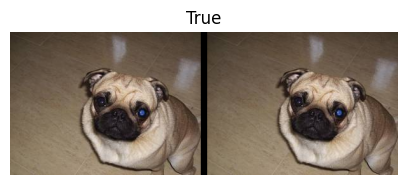

In [33]:
img = PILImage.create(files[0])
s = SiameseImage(img, img, True)
s.show()

In [37]:
img1 = PILImage.create(files[1])
s1 = SiameseImage(img, img1, False)
s1.show();

RuntimeError: ignored